In [ ]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, transpile, assemble, IBMQ, execute
from qiskit.circuit.library import RealAmplitudes, TwoLocal
from qiskit.visualization import plot_histogram
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from qiskit.circuit.library import PauliFeatureMap, ZZFeatureMap
from qiskit.opflow import Gradient, NaturalGradient, PauliExpectation, CircuitSampler
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit.algorithms.optimizers import GradientDescent, SPSA, QNSPSA
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier, VQC, QGAN, QSVC
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.kernels import QuantumKernel
from IPython.display import display, Math, Latex
from math import pi, log
import random
import time


%matplotlib inline

In [ ]:

backend = Aer.get_backend('qasm_simulator')
q_instance = QuantumInstance(backend, shots = 1024, seed_simulator = 2718, seed_transpiler = 2718)
#Prepare 4 random 4-qubit quantum states of your choice.
n = 4 # number of qubits

## Create and train a variational circuit that transforms input states into predefined output states. Namely
if random state 1 is provided, it returns state |0011>
if random state 2 is provided, it returns state |0101>
if random state 3 is provided, it returns state |1010>
if random state 4 is provided, it returns state |1100>

#### so here we have 2^4  possible states from a 4-qubit register.
  
  ### all possible states are:
 0:[0, 0, 0, 0],
 1: [0, 0, 0, 1],
 2: [0, 0, 1, 0],
 3: [0, 0, 1, 1],
 4: [0, 1, 0, 0],
 5: [0, 1, 0, 1],
 6: [0, 1, 1, 0],
 7: [0, 1, 1, 1],
 8: [1, 0, 0, 0],
 9: [1, 0, 0, 1],
 10: [1, 0, 1, 0],
 11: [1, 0, 1, 1],
 12: [1, 1, 0, 0],
 13: [1, 1, 0, 1],
 14: [1, 1, 1, 0],
 15: [1, 1, 1, 1],
   ### output states are:
 3: [0, 0, 1, 1],
 5: [0, 1, 0, 1],
 10: [1, 0, 1, 0],
 12: [1, 1, 0, 0],
 
 





In [ ]:

all_states = [[a, b, c, d] for a in range(2) for b in range(2) for c in range(2) for d in range(2)]
all_states_dict = {}
for i, e in enumerate(all_states):
    all_states_dict[i] = e
all_states_dict

In [ ]:
output_states =  {
    0: '0011',
    1: '0101',
    2: '1010',
    3: '1100'
}
print(output_states)

In [ ]:
def random_states():
    states = []
    str_inp_states = []
    
    while len(states) < 4:
        qc = QuantumCircuit(4)
        qc.h(range(4))
        qc.measure_all()
        sim = Aer.get_backend('statevector_simulator')
        input_state = list(sim.run(assemble(qc)).result().get_counts())[0]
        if input_state not in str_inp_states:
            output_state = len(states)
            str_inp_states.append(input_state)
            states.append([[int(x) for x in list(input_state)], [output_state]])
            
    a = []
    for s in states:
        a0 = s[0]
        for a1 in s[1]:
            a0.append(a1)
        a.append(a0)
    
    return a

In [ ]:

training_states = random_states()
training_states

In [ ]:
training_input_states = ['x0', 'x1', 'x2', 'x3']


In [ ]:
inp_out_states = {
    training_input_states[0]: '0011',
    training_input_states[1]: '0101',
    training_input_states[2]: '1010',
    training_input_states[3]: '1100'
}
inp_out_states

In [ ]:

df = pd.DataFrame({})
for i in range(200):
    choice = np.array(training_states[np.random.randint(0, 4)])
    df = df.append([choice.ravel().tolist()], ignore_index=True)
df.columns = ['x0', 'x1', 'x2', 'x3', 'y']

In [ ]:
features = ['x0', 'x1', 'x2', 'x3']
target = 'y'
df.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[features].to_numpy(), df[target].to_numpy(), test_size=0.2)

we gonna follow these map from Qiskit summer scholl 2021:
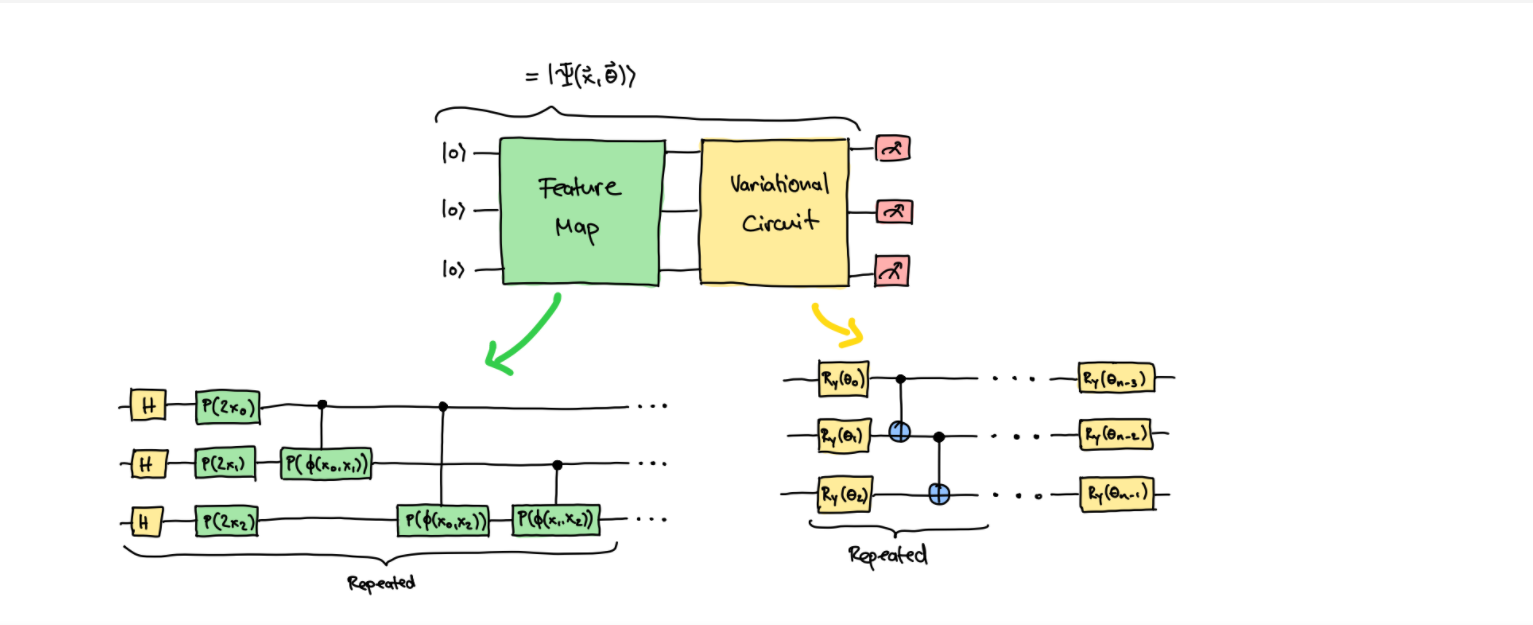
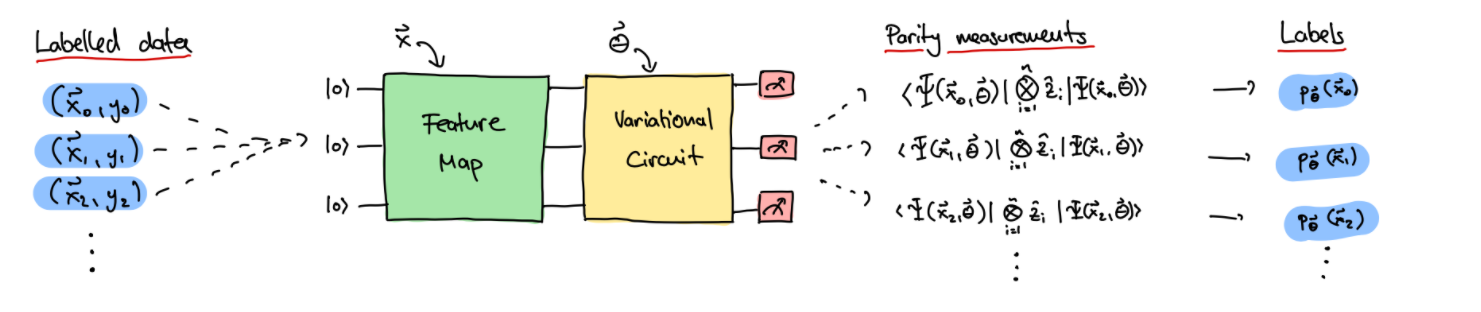


### Building a variational quantum classifier

Let's get the constituents we need:

* a Feature Map to encode the data
* an Ansatz to train
* an Observable to evaluate

We'll use a standard feature map from the circuit library.

In [ ]:
from qiskit.circuit.library import ZZFeatureMap

dim = 4
feature_map = ZZFeatureMap(dim, reps=2)  # let's keep it simple!
feature_map.draw('mpl', style='iqx')

We don't care about complex amplitudes so let's use an ansatz with only real amplitudes.

In [ ]:
ansatz = RealAmplitudes(num_qubits=dim, entanglement='linear', reps=2)  # also simple here!
ansatz.draw('mpl', style='iqx')

Put together our circuit is

In [ ]:
circuit = feature_map.compose(ansatz)
circuit.draw('mpl', style='iqx')

And we'll use global $\bigotimes_{i} \hat Z_i$ operators for the expectation values.


In [ ]:
from qiskit.opflow import Z, X, Y, I, StateFn
hamiltonian = Z ^ Z ^ Z ^ Z  # global Z operators


## Classifying our data

it's time to classify the data. I'am using Qiskit's ML package for that and it's ``OpflowQNN`` class to describe the circuit and expectation value along with a ``NeuralNetworkClassifier`` for the training.

First, we'll do vanilla gradient descent.

In [ ]:
gd_qnn_loss = []
def gd_qnn_callback(*args):
    gd_qnn_loss.append(args[2])
    
gd = GradientDescent(maxiter=100, learning_rate=0.01, callback=gd_qnn_callback)

In [ ]:
from qiskit_machine_learning.neural_networks import OpflowQNN

qnn_expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(circuit)

qnn = OpflowQNN(qnn_expectation, 
                input_params=list(feature_map.parameters), 
                weight_params=list(ansatz.parameters),
                exp_val=PauliExpectation(),
                gradient=Gradient(),  # <-- Parameter-Shift gradients
                quantum_instance=q_instance)

define the classifier, which takes the QNN, the loss and the optimizer.

In [ ]:
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
classifier = NeuralNetworkClassifier(qnn, optimizer=gd)

... and train!

In [ ]:
classifier.fit(X_train, y_train)

In [ ]:
score = classifier.score(X_test, y_test)
print(f'Classification score: {score}')

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(gd_loss, label='vanilla gradient descent')
plt.axhline(-1, ls='--', c='tab:red', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()

we can now train with the QNN with natural gradient descent by replacing ``Gradient`` with ``NaturalGradient``.

In [ ]:
qng_qnn_loss = []
def qng_qnn_callback(*args):
    qng_qnn_loss.append(args[2])
    
gd = GradientDescent(maxiter=100, learning_rate=0.01, callback=qng_qnn_callback)


In [ ]:
qnn = OpflowQNN(qnn_expectation, 
                input_params=list(feature_map.parameters), 
                weight_params=list(ansatz.parameters),
                gradient=NaturalGradient(regularization='ridge'),  # <-- using Natural Gradients!
                quantum_instance=q_instance)
classifier = NeuralNetworkClassifier(qnn, optimizer=gd)#, initial_point=initial_point)

In [ ]:
classifier_ng = NeuralNetworkClassifier(qnn_ng, optimizer=gd_ng)

In [ ]:
classifier_ng.fit(X_train, y_train)

In [ ]:
score_ng = classifier_ng.score(X_test, y_test)
print(f'Classification score: {score_ng}')

In [ ]:

plt.figure(figsize=(12, 6))
plt.plot(gd_loss, 'tab:blue', label='vanilla gradient descent')
plt.plot(qng_loss, 'tab:green', label='quantum natural gradient')
plt.axhline(-1, ls='--', c='tab:red', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()